# The Hill-Tononi Neuron and Synapse Models

## Hans Ekkehard Plesser, NMBU/FZ Jülich/U Oslo, 2016-12-01

## Background

This notebook describes the neuron and synapse model proposed by Hill and Tononi in *J Neurophysiol* 93:1671-1698, 2005 ([doi:10.1152/jn.00915.2004](http://dx.doi.org/doi:10.1152/jn.00915.2004)) and their implementation in NEST. The notebook also contains some tests.

This description is based on the original publication and publications cited therein, an analysis of the source code of the original Synthesis implementation kindly provided by Sean Hill, and plausiblity arguments.

In what follows, I will refer to the original paper as [HT05].

## The Neuron Model

### Integration 

The original Synthesis implementation of the model uses Runge-Kutta integration with fixed 0.25 ms step size, and integrates channels dynamics first, followed by integration of membrane potential and threshold.

NEST, in contrast, integrates the complete 16-dimensional state using a single adaptive-stepsize Runge-Kutta-Fehlberg-4(5) solver from the GNU Science Library (`gsl_odeiv_step_rkf45`).

### Membrane potential

Membrane potential evolution is governed by [HT05, p 1677]

\begin{equation}
\frac{\text{d}V}{\text{d}t} = \frac{-g_{\text{NaL}}(V-E_{\text{Na}})
-g_{\text{KL}}(V-E_{\text{K}})+I_{\text{syn}}+I_{\text{int}}}{\tau_{\text{m}}}
-\frac{g_{\text{spike}}(V-E_{\text{K}})}{\tau_{\text{spike}}}
\end{equation}

- The equation does not contain membrane capacitance. As a side-effect, all conductances are dimensionless.
- Na and K leak conductances $g_{\text{NaL}}$ and $g_{\text{KL}}$ are constant, although $g_{\text{KL}}$ may be adjusted on slow time scales to mimic neuromodulatory effects.
- Reversal potentials $E_{\text{Na}}$ and $E_{\text{K}}$ are assumed constant.
- Synaptic currents $I_{\text{syn}}$ and intrinsic currents $I_{\text{int}}$ are discussed below. In contrast to the paper, they are shown with positive sign here (just change in notation).
- The last term is a re-polarizing current only active during the refractory period, see below. Note that it has a different (faster) time constant than the other currents. It might have been more natural to use the same time constant for all currents and instead adjust $g_{\text{spike}}$. We follow the original approach here.

### Threshold, Spike generation and refractory effects

The threshold evolves according to [HT05, p 1677]

\begin{equation}
\frac{\text{d}\theta}{\text{d}t} = -\frac{\theta-\theta_{\text{eq}}}{\tau_{\theta}}
\end{equation}

The neuron emits a single spike if 
- it is not refractory
- membrane potential crosses the threshold, $V\geq\theta$

Upon spike emission,
- $V \leftarrow E_{\text{Na}}$
- $\theta \leftarrow E_{\text{Na}}$
- the neuron becomes refractory for time $t_{\text{spike}}$ (`t_ref` in NEST)

The repolarizing current is active during, and only during the refractory period:
\begin{equation}
g_{\text{spike}} = \begin{cases}  1  & \text{neuron is refractory}\\
 0 & \text{else} \end{cases}
\end{equation}

During the refractory period, the neuron cannot fire new spikes, but all state variables evolve freely, nothing is clamped. 

The model of spiking and refractoriness is based on Synthesis model `PulseIntegrateAndFire`.

### Intrinsic currents

Note that not all intrinsic currents are active in all populations of the network model presented in [HT05, p1678f].

Intrinsic currents are based on the Hodgkin-Huxley description, i.e.,

\begin{align}
I_X &= g_{\text{peak}, X} m_X(V, t)^N_X h_X(V, t)(V-E_X) \\
\frac{\text{d}m_X}{\text{d}t} &= \frac{m_X^{\infty}-m_X}{\tau_{m,X}(V)}\\
\frac{\text{d}h_X}{\text{d}t} &= \frac{h_X^{\infty}-h_X}{\tau_{h,X}(V)}
\end{align}

where $I_X$  is the current through channel $X$ and $m_X$ and $h_X$ the activation and inactivation  variables for channel $X$.

#### Pacemaker current $I_h$

Synthesis: `IhChannel`

\begin{align}
N_h & = 1 \\
m_h^{\infty}(V) &= \frac{1}{1+\exp\left(\frac{V+75\text{mV}}{5.5\text{mV}}\right)} \\
\tau_{m,h}(V) &= \frac{1}{\exp(-14.59-0.086V) + \exp(-1.87  + 0.0701V)} \\
h_h(V, t) &\equiv 1 
\end{align}

Note that subscript $h$ in some cases above marks the $I_h$ channel.

#### Low-threshold calcium current $I_T$

Synthesis: `ItChannel`

##### Equations given in paper 

\begin{align}
N_T & \quad \text{not given} \\
m_T^{\infty}(V) &= 1/\{1 +  \exp[ -(V +  59.0)/6.2]\} \\
\tau_{m,T}(V) &= \{0.22/\exp[ -(V  + 132.0)/ 16.7]\} +  \exp[(V  + 16.8)/18.2] +  0.13\\
h_T^{\infty}(V) &= 1/\{1 +  \exp[(V +  83.0)/4.0]\} \\
\tau_{h,T}(V) &= \langle  8.2 +  \{56.6 +  0.27 \exp[(V +  115.2)/5.0]\}\rangle / \{1.0 +  \exp[(V +  86.0)/3.2]\}
\end{align}

Note the following:
- The channel model is based on Destexhe et al, *J Neurophysiol* 76:2049 (1996).
- In the equation for $\tau_{m,T}$, the second exponential term must be added to the first (in the denominator) to make dimensional sense; 0.13 and 0.22 have unit ms.
- In the equation for $\tau_{h,T}$, the $\langle \rangle$ brackets should be dropped, so that $8.2$ is not divided by the $1+\exp$ term. Otherwise, it could have been combined with the $56.6$.
- This analysis is confirmed by code analysis and comparison with Destexhe et al, *J Neurophysiol* 76:2049 (1996), Eq 5.
- From Destexhe et al we also find $N_T=2$.

##### Corrected equations

This leads to the following equations, which are implemented in Synthesis and NEST.

\begin{align}
N_T &= 2 \\
m_T^{\infty}(V) &=  \frac{1}{1+\exp\left(-\frac{V+59\text{mV}}{6.2\text{mV}}\right)}\\
\tau_{m,T}(V) &= 0.13\text{ms} 
  + \frac{0.22\text{ms}}{\exp\left(-\frac{V  + 132\text{mV}}{16.7\text{mV}}\right) + \exp\left(\frac{V +  16.8\text{mV}}{18.2\text{mV}}\right)} \\ 
h_T^{\infty}(V) &=  \frac{1}{1+\exp\left(\frac{V+83\text{mV}}{4\text{mV}}\right)}\\
\tau_{h,T}(V) &= 8.2\text{ms} +  \frac{56.6\text{ms} +  0.27\text{ms} \exp\left(\frac{V   + 115.2\text{mV}}{5\text{mV}}\right)}{1 +   \exp\left(\frac{V  + 86\text{mV}}{3.2\text{mV}}\right)}
\end{align}

#### Persistent Sodium Current $I_{NaP}$

Synthesis: `INaPChannel`

This model has only activation ($m$) and uses the steady-state value, so the only relevant equation is that for $m$. In the paper, it is given as

\begin{equation}
m_{NaP}^{\infty}(V) = 1/[1+\exp(-V+55.7)/7.7]
\end{equation}

Dimensional analysis indicates that the division by $7.7$ should be in the argument of the exponential, and the minus sign needs to be moved so that the current activates as the neuron depolarizes leading to the corrected equation

\begin{equation}
m_{NaP}^{\infty}(V) = \frac{1}{1+\exp\left(-\frac{V+55.7\text{mV}}{7.7\text{mV}}\right)}
\end{equation}

This equation is implemented in NEST and Synthesis and is the one found in Compte et al (2003), cited by [HT05, p 1679].

##### Corrected exponent

According to Compte et al (2003), $N_{NaP}=3$, i.e.,
\begin{equation}
I_{NaP} = g_{\text{peak,NaP}}(m_{NaP}^{\infty}(V))^3(V-E_{NaP})
\end{equation}
This equation is also given in a comment in Synthesis, but is missing from the implementation.

**Note: NEST implements the equation according to Compte et al (2003) with $N_{NaP}=3$, while Synthesis uses $N_{NaP}=1$.**


#### Depolarization-activated Potassium Current $I_{DK}$

Synthesis: `IKNaChannel`

This model also only has a single activation variable $m$, following more complicated dynamics expressed by $D$.

##### Equations in paper

\begin{align}
 dD/dt &= D_{\text{influx}} - D(1-D_{\text{eq}})/\tau_D \\
 D_{\text{influx}} &= 1/\{1+ \exp[-(V-D_{\theta})/\sigma_D]\} \\
 m_{DK}^{\infty} &= 1/1 + (d_{1/2}D)^{3.5}
\end{align}

There are several problems with these equations.

In the steady state the first equation becomes
\begin{equation}
 0 = - D(1-D_{\text{eq}})/\tau_D 
 \end{equation}
 with solution
 \begin{equation}
 D = 0
\end{equation}
This contradicts both the statement [HT05, p. 1679] that $D\to D_{\text{eq}}$ in this case, and the requirement that $D>0$ to avoid a singluarity in the equation for $m_{DK}^{\infty}$. The most plausible correction is
\begin{equation}
 dD/dt = D_{\text{influx}} - (D-D_{\text{eq}})/\tau_D 
\end{equation}

The third equation appears incorrect and logic as well as Wang et al, *J Neurophysiol* 89:3279–3293, 2003, Eq 9, cited in [HT05, p 1679], indicate that the correct equation is

\begin{equation}
 m_{DK}^{\infty} = 1/(1 + (d_{1/2} / D)^{3.5})
\end{equation}



##### Corrected equations

The equations for this channel implemented in NEST are thus

\begin{align}
I_{DK} &= - g_{\text{peak},DK} m_{DK}(V,t) (V - E_{DK})\\
 m_{DK} &= \frac{1}{1 + \left(\frac{d_{1/2}}{D}\right)^{3.5}}\\
 \frac{dD}{dt} &= D_{\text{influx}}(V) - \frac{D-D_{\text{eq}}}{\tau_D} = \frac{D_{\infty}(V)-D}{\tau_D} \\
 D_{\infty}(V) &= \tau_D D_{\text{influx}}(V) + {D_{\text{eq}}}\\
 D_{\text{influx}} &= \frac{D_{\text{influx,peak}}}{1+ \exp\left(-\frac{V-D_{\theta}}{\sigma_D}\right)} 
\end{align}

with 

|$D_{\text{influx,peak}}$|$D_{\text{eq}}$|$\tau_D$|$D_{\theta}$|$\sigma_D$|$d_{1/2}$|
| --: | --: | --: | --: | --: | --: |
|$0.025\text{ms}^{-1}$ |$0.001$|$1250\text{ms}$|$-10\text{mV}$|$5\text{mV}$|$0.25$|

Note the following:
- $D_{eq}$ is the equilibrium value only for $D_{\text{influx}}(V)=0$, i.e., in the limit $V\to -\infty$ and $t\to\infty$.
- The actual steady-state value is $D_{\infty}$.
- $d_{1/2}$, $D$, $D_{\infty}$, and $D_{\text{eq}}$ have identical, but arbitrary units, so we can assume them dimensionless ($D$ is a "factor" that in an abstract way represents concentrations).
- $D_{\text{influx}}$ and $D_{\text{influx,peak}}$ are rates of change of $D_{\infty}$ and thus have units of inverse time.
- $m_{DK}$ is a steep sigmoid which is almost 0 or 1 except for a narrow window around $d_{1/2}$.
- To the left of this window, $I_{DK}\approx 0$.
- To the right of this window, $I_{DK}\sim -(V-E_{DK})$.
- $m_{DK}$ is not integrated over time, instead it is an instantaneous transform of $D$, which is integrated over time.

**Note: The differential equation for $dD/dt$ differs from the one implemented in Synthesis.**

### Synaptic channels

These are described in [HT05, p 1678]. Synaptic channels are conductance based with double-exponential time course (beta functions) and normalized for peak conductance. NMDA channels are additionally voltage gated, as described below.

Let $\{t_{(j, X)}\}$ be the set of all spike arrival times, where $X$ indicates the synapse model and $j$ enumerates spikes. Then the total synaptic input is given by

\begin{equation}
I_{\text{syn}}(t) = - \sum_{\{t_{(j, X)}\}} \bar{g}_X(t-t_{(j, X)}) (V-E_X)
\end{equation}

#### Standard Channels

Synthesis: `SynChannel`

The conductance change due to a single input spike at time $t=0$ through a channel of type $X$ is given by (see below for exceptions)

\begin{align}
    \bar{g}_X(t) &= g_X(t)\\
    g_X(t) &= g_{\text{peak}, X}\frac{\exp(-t/\tau_1) - \exp(-t/\tau_2)}{
                 \exp(-t_{\text{peak}}/\tau_1) - \exp(-t_{\text{peak}}/\tau_2)} \Theta(t)\\
     t_{\text{peak}} &= \frac{\tau_2 \tau_1}{\tau_2 - \tau_1} \ln\frac{ \tau_2}{\tau_1}
\end{align} 

where $t_{\text{peak}}$ is the time of the conductance maximum and $\tau_1$ and $\tau_2$ are synaptic rise- and decay-time, respectively; $\Theta(t)$ is the Heaviside step function. The equation is integrated using exact integration in Synthesis; in NEST, it is included in the ODE-system integrated using the Runge-Kutta-Fehlberg 4(5) solver from GSL.

The "indirection" from $g$ to $\bar{g}$ is required for consistent notation for NMDA channels below.

These channels are used for AMPA, GABA_A and GABA_B channels.

#### NMDA Channels

Synthesis: `SynNMDAChannel`

For the NMDA channel we have
\begin{equation}
\bar{g}_{\text{NMDA}}(t) = m(V, t) g_{\text{NMDA}}(t)
\end{equation}
with $g_{\text{NMDA}}(t)$ from above. 

The voltage-dependent gating $m(V, t)$ is defined as follows (based on textual description, Vargas-Caballero and Robinson *J Neurophysiol* 89:2778–2783, 2003, [doi:10.1152/jn.01038.2002](http://dx.doi.org/10.1152/jn.01038.2002), and code inspection):

\begin{align}
     m(V, t) &= a(V) m_{\text{fast}}^*(V, t) + ( 1 - a(V) ) m_{\text{slow}}^*(V, t)\\
     a(V)    &= 0.51 - 0.0028 V \\
     m^{\infty}(V) &= \frac{1}{ 1 + \exp\left( -S_{\text{act}} ( V - V_{\text{act}} ) \right) } \\
     m_X^*(V, t) &= \min(m^{\infty}(V), m_X(V, t))\\
      \frac{\text{d}m_X}{\text{d}t} &= \frac{m^{\infty}(V) - m_X }{ \tau_{\text{Mg}, X}}
\end{align} 

where $X$ is "slow" or "fast". $a(V)$ expresses voltage-dependent weighting between slow and fast unblocking, $m^{\infty}(V)$ the steady-state value of the proportion of unblocked NMDA-channels, the minimum condition in $m_X^*(V,t)$ the instantaneous blocking and the differential equation for $m_X(V,t)$ the unblocking dynamics.

Synthesis uses tabluated values for $m^{\infty}$. NEST uses the best fit of $V_{\text{act}}$ and $S_{\text{act}}$  to the tabulated data for conductance table `fNMDA`.

**Note**: NEST also supports instantaneous NMDA dynamics using a boolean switch. In that case $m(V, t)=m^{\infty}(V)$. 

### No synaptic "minis"

Synaptic "minis" due to spontaneous release of neurotransmitter quanta [HT05, p 1679] are not included in the NEST implementation of the Hill-Tononi model, because the total mini input rate for a cell was just 2 Hz and they cause PSP changes by $0.5 \pm 0.25$mV only and thus should have minimal effect.

## The Synapse Depression Model

The synapse depression model is implemented in NEST as `ht_synapse`, in Synthesis in `SynChannel` and `VesiclePool`.

$P\in[0, 1]$ describes the state of the presynaptic vesicle pool. Spikes are transmitted with an effective weight
\begin{equation}
w_{\text{eff}} = P w
\end{equation}
where $w$ is the nominal weight of the synapse.

### Evolution of $P$ in paper and Synthesis implementation

According to [HT05, p 1678], the pool $P$ evolves according to
\begin{equation}
\frac{\text{d}P}{\text{d}t} = -\:\text{spike}\:\delta_P P+\frac{P_{\text{peak}}-P}{\tau_P}
\end{equation}
where
- $\text{spike}=1$ while the neuron is in spiking state, 0 otherwise
- $P_{\text{peak}}=1$ 
- $\delta_P = 0.5$ by default
- $\tau_P = 500\text{ms}$ by default
Since neurons are in spiking state for one integration time step $\Delta t$, this suggest that the effect of a spike on the vesicle pool is approximately
\begin{equation}
P \leftarrow ( 1 - \Delta t \delta_P ) P
\end{equation}
For default parameters $\Delta t=0.25\text{ms}$ and $\delta_P=0.5$, this means that a single spike reduces the pool by 1/8 of its current size.

### Evolution of $P$ in the NEST implementation

In NEST, we modify the equations above to obtain a definite jump in pool size on transmission of a spike, without any dependence on the integration time step (fixing explicitly $P_{\text{peak}}$):

\begin{align}
\frac{\text{d}P}{\text{d}t} &= \frac{1-P}{\tau_P} \\
P &\leftarrow ( 1 - \delta_P^*) P 
\end{align}

$P$ is only updated when a spike passes the synapse, in the following way (where $\Delta$ is the time since the last spike through the same synapse):

1. Recuperation: $P\leftarrow 1 - ( 1 - P ) \exp( -\Delta / \tau_P )$
2. Spike transmission with $w_{\text{eff}} = P w$
3. Depletion: $P \leftarrow ( 1 - \delta_P^*) P$

To achieve approximately the same depletion as in Synthesis, use $\delta_P^*=\Delta t\delta_p$.








## Tests of the Models

In [1]:
import sys
import math
import numpy as np
import pandas as pd
import scipy.optimize as so
import scipy.integrate as si
import matplotlib.pyplot as plt
import nest

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 3)

### Neuron Model

#### Passive properties

Test relaxation of neuron and threshold to equilibrium values in absence of intrinsic currents and input. We then have
\begin{align}
\tau_m \dot{V}&= \left[-g_{NaL}(V-E_{Na})-g_{KL}(V-E_K)\right] = -(g_{NaL}+g_{KL})V+(g_{NaL}E_{Na}+g_{KL}E_K)\\
\Leftrightarrow\quad \tau_{\text{eff}}\dot{V} &= -V+V_{\infty}\\
V_{\infty} &= \frac{g_{NaL}E_{Na}+g_{KL}E_K}{g_{NaL}+g_{KL}}\\
\tau_{\text{eff}}&=\frac{\tau_m}{g_{NaL}+g_{KL}}
\end{align}
with solution
\begin{equation}
V(t) = V_0 e^{-\frac{t}{\tau_{\text{eff}}}} + V_{\infty}\left(1-e^{-\frac{t}{\tau_{\text{eff}}}} \right)
\end{equation}
and for the threshold
\begin{equation}
\theta(t) = \theta_0 e^{-\frac{t}{\tau_{\theta}}} + \theta_{eq}\left(1-e^{-\frac{t}{\tau_{\theta}}} \right)
\end{equation}

In [2]:
def Vpass(t, V0, gNaL, ENa, gKL, EK, taum, I=0):
    tau_eff = taum/(gNaL + gKL)
    Vinf = (gNaL*ENa + gKL*EK + I)/(gNaL + gKL)
    return V0*np.exp(-t/tau_eff) + Vinf*(1-np.exp(-t/tau_eff))

def theta(t, th0, theq, tauth):
    return th0*np.exp(-t/tauth) + theq*(1-np.exp(-t/tauth))

In [3]:
nest.ResetKernel()
nest.SetDefaults('ht_neuron', {'g_peak_NaP': 0., 'g_peak_KNa': 0.,
                               'g_peak_T': 0., 'g_peak_h': 0.,
                               'tau_theta': 10.})
hp = nest.GetDefaults('ht_neuron')

V_0 = [-100., -70., -55.]
th_0 = [-65., -51., -10.]
T_sim = 20.

nrns = nest.Create('ht_neuron', n=len(V_0), params={'V_m': V_0, 'theta': th_0}) 

nest.Simulate(T_sim)
V_th_sim = nrns.get(['V_m', 'theta'])

for (V0, th0, Vsim, thsim) in zip(V_0, th_0, V_th_sim['V_m'], V_th_sim['theta']):
    Vex = Vpass(T_sim, V0, hp['g_NaL'], hp['E_Na'], hp['g_KL'], hp['E_K'], hp['tau_m'])
    thex = theta(T_sim, th0, hp['theta_eq'], hp['tau_theta'])
    print('Vex  = {:.3f}, Vsim  = {:.3f}, Vex-Vsim   = {:.3e}'.format(Vex, Vsim, Vex-Vsim))
    print('thex = {:.3f}, thsim = {:.3f}, thex-thsim = {:.3e}'.format(thex, thsim, thex-thsim))

Vex  = -76.694, Vsim  = -76.694, Vex-Vsim   = -1.847e-13
thex = -52.895, thsim = -52.895, thex-thsim = -3.553e-13
Vex  = -70.000, Vsim  = -70.000, Vex-Vsim   = 0.000e+00
thex = -51.000, thsim = -51.000, thex-thsim = 0.000e+00
Vex  = -66.653, Vsim  = -66.653, Vex-Vsim   = 1.137e-13
thex = -45.451, thsim = -45.451, thex-thsim = 1.009e-12


Agreement is excellent.

#### Spiking without intrinsic currents or synaptic input

The equations above hold for input current $I(t)$, but with
\begin{equation}
V_{\infty}(I) = \frac{g_{NaL}E_{Na}+g_{KL}E_K}{g_{NaL}+g_{KL}} + \frac{I}{g_{NaL}+g_{KL}}
\end{equation}
In NEST, we need to inject input current into the `ht_neuron` with a `dc_generator`, whence the current will set on only at a later time and we need to take this into account. For simplicity, we assume that $V$ is initialized to $V_{\infty}(I=0)$ and that current onset is at $t_I$. We then have for $t\geq t_I$
\begin{equation}
V(t) = V_{\infty}(0) e^{-\frac{t-t_I}{\tau_{\text{eff}}}} + V_{\infty}(I)\left(1-e^{-\frac{t-t_I}{\tau_{\text{eff}}}} \right)
\end{equation}
If we also initialize $\theta=\theta_{\text{eq}}$, the threshold is constant and we have the first spike at
\begin{align}
V(t) &= \theta_{\text{eq}}\\
\Leftrightarrow\quad t &= t_I -\tau_{\text{eff}} \ln \frac{\theta_{\text{eq}}-V_{\infty}(I)}{V_{\infty}(0)-V_{\infty}(I)}
\end{align}

In [4]:
def t_first_spike(gNaL, ENa, gKL, EK, taum, theq, tI, I):
    tau_eff = taum/(gNaL + gKL)
    Vinf0 = (gNaL*ENa + gKL*EK)/(gNaL + gKL)
    VinfI = (gNaL*ENa + gKL*EK + I)/(gNaL + gKL)
    return tI - tau_eff * np.log((theq-VinfI) / (Vinf0-VinfI))

In [5]:
nest.ResetKernel()
nest.SetKernelStatus({'resolution': 0.001})
nest.SetDefaults('ht_neuron', {'g_peak_NaP': 0., 'g_peak_KNa': 0.,
                               'g_peak_T': 0., 'g_peak_h': 0.})
hp = nest.GetDefaults('ht_neuron')

I = [25., 50., 100.]
tI = 1.
delay = 1.
T_sim = 40.

nrns = nest.Create('ht_neuron', n=len(I))
dcgens = nest.Create('dc_generator', n=len(I), params={'amplitude': I, 'start': tI})
srs = nest.Create('spike_recorder', n=len(I))
nest.Connect(dcgens, nrns, 'one_to_one', {'delay': delay})
nest.Connect(nrns, srs, 'one_to_one')
nest.Simulate(T_sim)

t_first_sim = [t[0] for t in srs.get('events', 'times')]

for dc, tf_sim in zip(I, t_first_sim):
    tf_ex = t_first_spike(hp['g_NaL'], hp['E_Na'], hp['g_KL'], hp['E_K'], 
                          hp['tau_m'], hp['theta_eq'], tI+delay, dc)
    print('tex  = {:.4f}, tsim  = {:.4f}, tex-tsim = {:.4f}'.format(tf_ex, 
                                                                    tf_sim, 
                                                                    tf_ex-tf_sim))


tex  = 34.4056, tsim  = 34.4060, tex-tsim = -0.0004
tex  = 10.1174, tsim  = 10.1180, tex-tsim = -0.0006
tex  = 5.4503, tsim  = 5.4510, tex-tsim = -0.0007


Agreement is as good as possible: All spikes occur in NEST at then end of the time step containing the expected spike time.

#### Inter-spike interval

After each spike, $V_m = \theta = E_{Na}$, i.e., all memory is erased. We can thus treat ISIs independently. $\theta$ relaxes according to the equation above. For $V_m$, we have during $t_{\text{spike}}$ after a spike

\begin{align}
\tau_m\dot{V} &= {-g_{\text{NaL}}(V-E_{\text{Na}})
-g_{\text{KL}}(V-E_{\text{K}})+I}
-\frac{\tau_m}{\tau_{\text{spike}}}({V-E_{\text{K}}})\\
&=  -(g_{NaL}+g_{KL}+\frac{\tau_m}{\tau_{\text{spike}}})V+(g_{NaL}E_{Na}+g_{KL}E_K+\frac{\tau_m}{\tau_{\text{spike}}}E_K)
\end{align}

thus recovering the same for for the solution but with

\begin{align}
\tau^*_{\text{eff}} &= \frac{\tau_m}{g_{NaL}+g_{KL}+\frac{\tau_m}{\tau_{\text{spike}}}}\\
V^*_{\infty} &= \frac{g_{NaL}E_{Na}+g_{KL}E_K+I+\frac{\tau_m}{\tau_{\text{spike}}}E_K}{g_{NaL}+g_{KL}+\frac{\tau_m}{\tau_{\text{spike}}}}
\end{align}

Assuming that the ISI is longer than the refractory period $t_{\text{spike}}$, and we had a spike at time $t_s$, then we have at $t_s+t_{\text{spike}}$

\begin{align}
V^* &= V(t_s+t_{\text{spike}}) = E_{Na} e^{-\frac{t_{\text{spike}}}{\tau^*_{\text{eff}}}} + V^*_{\infty}(I)\left(1-e^{-\frac{t_{\text{spike}}}{\tau^*_{\text{eff}}}} \right)\\
\theta^* &= \theta(t_s+t_{\text{spike}}) = E_{Na} e^{-\frac{t_{\text{spike}}}{\tau_{\theta}}} + \theta_{eq}\left(1-e^{-\frac{t_{\text{spike}}}{\tau_{\theta}}} \right)\\
t^* &= t_s+t_{\text{spike}}
\end{align}

For $t>t^*$, the normal equations apply again, i.e.,
\begin{align}
V(t) &= V^* e^{-\frac{t-t^*}{\tau_{\text{eff}}}} + V_{\infty}(I)\left(1-e^{-\frac{t-t^*}{\tau_{\text{eff}}}} \right)\\
\theta(t) &= \theta^* e^{-\frac{t-t^*}{\tau_{\theta}}} + \theta_{\infty}\left(1-e^{-\frac{t-t^*}{\tau_{\theta}}}\right)
\end{align}

The time of the next spike is then given by
\begin{equation}
V(\hat{t}) = \theta(\hat{t})
\end{equation}
which can only be solved numerically. The ISI is then obtained as $\hat{t}-t_s$.

In [6]:
def Vspike(tspk, gNaL, ENa, gKL, EK, taum, tauspk, I=0):
    tau_eff = taum/(gNaL + gKL + taum/tauspk)
    Vinf = (gNaL*ENa + gKL*EK + I + taum/tauspk*EK)/(gNaL + gKL + taum/tauspk)
    return ENa*np.exp(-tspk/tau_eff) + Vinf*(1-np.exp(-tspk/tau_eff))

def thetaspike(tspk, ENa, theq, tauth):
    return ENa*np.exp(-tspk/tauth) + theq*(1-np.exp(-tspk/tauth))

def Vpost(t, tspk, gNaL, ENa, gKL, EK, taum, tauspk, I=0):
    Vsp = Vspike(tspk, gNaL, ENa, gKL, EK, taum, tauspk, I)
    return Vpass(t-tspk, Vsp, gNaL, ENa, gKL, EK, taum, I)

def thetapost(t, tspk, ENa, theq, tauth):
    thsp = thetaspike(tspk, ENa, theq, tauth)
    return theta(t-tspk, thsp, theq, tauth)

def threshold(t, tspk, gNaL, ENa, gKL, EK, taum, tauspk, I, theq, tauth):
    return Vpost(t, tspk, gNaL, ENa, gKL, EK, taum, tauspk, I) - thetapost(t, tspk, ENa, theq, tauth)

In [7]:
nest.ResetKernel()
nest.SetKernelStatus({'resolution': 0.001})
nest.SetDefaults('ht_neuron', {'g_peak_NaP': 0., 'g_peak_KNa': 0.,
                               'g_peak_T': 0., 'g_peak_h': 0.})
hp = nest.GetDefaults('ht_neuron')

I = [25., 50., 100.]
tI = 1.
delay = 1.
T_sim = 1000.

nrns = nest.Create('ht_neuron', n=len(I))
dcgens = nest.Create('dc_generator', n=len(I), params={'amplitude': I, 'start': tI})
srs = nest.Create('spike_recorder', n=len(I))
nest.Connect(dcgens, nrns, 'one_to_one', {'delay': delay})
nest.Connect(nrns, srs, 'one_to_one')
nest.Simulate(T_sim)

isi_sim = []
for ev in srs.events:
    t_spk = ev['times']
    isi = np.diff(t_spk)
    isi_sim.append((np.min(isi), np.mean(isi), np.max(isi)))

for dc, (isi_min, isi_mean, isi_max) in zip(I, isi_sim):
    isi_ex = so.bisect(threshold, hp['t_ref'], 50, 
                      args=(hp['t_ref'], hp['g_NaL'], hp['E_Na'], hp['g_KL'], hp['E_K'], 
                          hp['tau_m'], hp['tau_spike'], dc, hp['theta_eq'], hp['tau_theta']))
    print('isi_ex  = {:.4f}, isi_sim (min, mean, max)  = ({:.4f}, {:.4f}, {:.4f})'.format(
        isi_ex, isi_min, isi_mean, isi_max))

isi_ex  = 14.3144, isi_sim (min, mean, max)  = (14.3150, 14.3150, 14.3150)
isi_ex  = 5.6602, isi_sim (min, mean, max)  = (5.6610, 5.6610, 5.6610)
isi_ex  = 3.9718, isi_sim (min, mean, max)  = (3.9720, 3.9720, 3.9720)


- ISIs are as predicted: measured ISI is predicted rounded up to next time step
- ISIs are perfectly regular as expected

#### Intrinsic Currents

##### Preparations

In [8]:
nest.ResetKernel()
class Channel:
    """
    Base class for channel models in Python.
    """
    def tau_m(self, V):
        raise NotImplementedError()
    def tau_h(self, V):
        raise NotImplementedError()
    def m_inf(self, V):
        raise NotImplementedError()
    def h_inf(self, V):
        raise NotImplementedError()
    def D_inf(self, V):
        raise NotImplementedError()
    def dh(self, h, t, V):
        return (self.h_inf(V)-h)/self.tau_h(V)
    def dm(self, m, t, V):
        return (self.m_inf(V)-m)/self.tau_m(V)

In [9]:
def voltage_clamp(channel, DT_V_seq, nest_dt=0.1):
    "Run voltage clamp with voltage V through intervals DT."

    # NEST part
    nest_g_0 = {'g_peak_h': 0., 'g_peak_T': 0., 'g_peak_NaP': 0., 'g_peak_KNa': 0.}
    nest_g_0[channel.nest_g] = 1.
    
    nest.ResetKernel()
    nest.SetKernelStatus({'resolution': nest_dt})
    nrn = nest.Create('ht_neuron', params=nest_g_0)
    mm = nest.Create('multimeter', params={'record_from': ['V_m', 'theta', channel.nest_I],
                                           'interval': nest_dt})
    nest.Connect(mm, nrn)

    # ensure we start from equilibrated state
    nrn.set(V_m=DT_V_seq[0][1], equilibrate=True, voltage_clamp=True)
    for DT, V in DT_V_seq:
        nrn.set(V_m=V, voltage_clamp=True)
        nest.Simulate(DT)
    t_end = nest.GetKernelStatus('time')
    
    # simulate a little more so we get all data up to t_end to multimeter
    nest.Simulate(2 * nest.GetKernelStatus('min_delay'))
    
    tmp = pd.DataFrame(mm.events)
    nest_res = tmp[tmp.times <= t_end]
    
    # Control part
    t_old = 0.
    try:
        m_old = channel.m_inf(DT_V_seq[0][1])
    except NotImplementedError:
        m_old = None
    try:
        h_old = channel.h_inf(DT_V_seq[0][1])
    except NotImplementedError:
        h_old = None
    try:
        D_old = channel.D_inf(DT_V_seq[0][1])
    except NotImplementedError:
        D_old = None
        
    t_all, I_all = [], []
    if D_old is not None:
        D_all = []
        
    for DT, V in DT_V_seq:
        t_loc = np.arange(0., DT+0.1*nest_dt, nest_dt)
        I_loc = channel.compute_I(t_loc, V, m_old, h_old, D_old)
        t_all.extend(t_old + t_loc[1:])
        I_all.extend(I_loc[1:])
        if D_old is not None:
            D_all.extend(channel.D[1:])
        m_old = channel.m[-1] if m_old is not None else None
        h_old = channel.h[-1] if h_old is not None else None
        D_old = channel.D[-1] if D_old is not None else None
        t_old = t_all[-1]
        
    if D_old is None:
        ctrl_res = pd.DataFrame({'times': t_all, channel.nest_I: I_all})
    else:
        ctrl_res = pd.DataFrame({'times': t_all, channel.nest_I: I_all, 'D': D_all})

    return nest_res, ctrl_res

##### I_h channel

The $I_h$ current is governed by
\begin{align}
I_h &= g_{\text{peak}, h} m_h(V, t) (V-E_h) \\
\frac{\text{d}m_h}{\text{d}t} &= \frac{m_h^{\infty}-m_h}{\tau_{m,h}(V)}\\
m_h^{\infty}(V) &= \frac{1}{1+\exp\left(\frac{V+75\text{mV}}{5.5\text{mV}}\right)} \\
\tau_{m,h}(V) &= \frac{1}{\exp(-14.59-0.086V) + \exp(-1.87  + 0.0701V)}
\end{align}

We first inspect $m_h^{\infty}(V)$ and $\tau_{m,h}(V)$ to prepare for testing

In [10]:
nest.ResetKernel()
class Ih(Channel):
    
    nest_g = 'g_peak_h'
    nest_I = 'I_h'
    
    def __init__(self, ht_params):
        self.hp = ht_params
        
    def tau_m(self, V):
        return 1/(np.exp(-14.59-0.086*V) + np.exp(-1.87  + 0.0701*V))
    
    def m_inf(self, V):
        return 1/(1+np.exp((V+75)/5.5))

    def compute_I(self, t, V, m0, h0, D0):
        self.m = si.odeint(self.dm, m0, t, args=(V,))
        return - self.hp['g_peak_h'] * self.m * (V - self.hp['E_rev_h'])

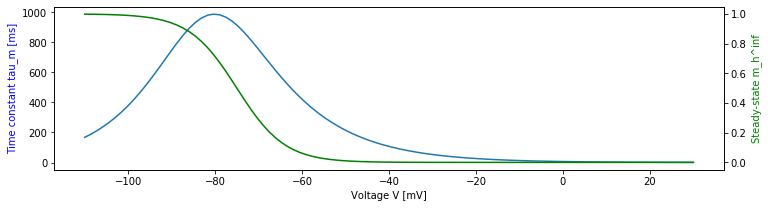

In [11]:
ih = Ih(nest.GetDefaults('ht_neuron'))

V = np.linspace(-110, 30, 100)
plt.plot(V, ih.tau_m(V));
ax = plt.gca();
ax.set_xlabel('Voltage V [mV]');
ax.set_ylabel('Time constant tau_m [ms]', color='b');
ax2 = ax.twinx()
ax2.plot(V, ih.m_inf(V), 'g');
ax2.set_ylabel('Steady-state m_h^inf', color='g');

- The time constant is extremely long, up to 1s, for relevant voltages where $I_h$ is perceptible. We thus need long test runs.
- Curves are in good agreement with Fig 5 of Huguenard and McCormick, *J Neurophysiol* 68:1373, 1992, cited in [HT05]. I_h data there was from guinea pig slices at 35.5 C and needed no temperature adjustment.

We now run a voltage clamp experiment starting from the equilibrium value.

In [12]:
ih = Ih(nest.GetDefaults('ht_neuron'))
nr, cr = voltage_clamp(ih, [(500, -65.), (500, -80.), (500, -100.), (500, -90.), (500, -55.)]) 

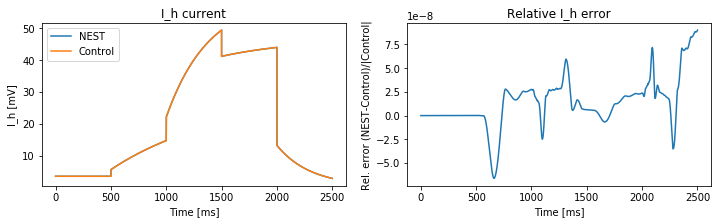

In [13]:
plt.subplot(1, 2, 1)
plt.plot(nr.times, nr.I_h, label='NEST');
plt.plot(cr.times, cr.I_h, label='Control');
plt.legend(loc='upper left');
plt.xlabel('Time [ms]');
plt.ylabel('I_h [mV]');
plt.title('I_h current')

plt.subplot(1, 2, 2)
plt.plot(nr.times, (nr.I_h-cr.I_h)/np.abs(cr.I_h));
plt.title('Relative I_h error')
plt.xlabel('Time [ms]');
plt.ylabel('Rel. error (NEST-Control)/|Control|');

- Agreement is very good
- Note that currents have units of $mV$ due to choice of dimensionless conductances.

##### I_T Channel

The corrected equations used for the $I_T$ channel in NEST are
\begin{align}
I_T &= g_{\text{peak}, T} m_T^2(V, t) h_T(V,t) (V-E_T) \\
m_T^{\infty}(V) &=  \frac{1}{1+\exp\left(-\frac{V+59\text{mV}}{6.2\text{mV}}\right)}\\
\tau_{m,T}(V) &= 0.13\text{ms} 
  + \frac{0.22\text{ms}}{\exp\left(-\frac{V  + 132\text{mV}}{16.7\text{mV}}\right) + \exp\left(\frac{V +  16.8\text{mV}}{18.2\text{mV}}\right)} \\ 
h_T^{\infty}(V) &=  \frac{1}{1+\exp\left(\frac{V+83\text{mV}}{4\text{mV}}\right)}\\
\tau_{h,T}(V) &= 8.2\text{ms} +  \frac{56.6\text{ms} +  0.27\text{ms} \exp\left(\frac{V   + 115.2\text{mV}}{5\text{mV}}\right)}{1 +   \exp\left(\frac{V  + 86\text{mV}}{3.2\text{mV}}\right)}
\end{align}

In [14]:
nest.ResetKernel()
class IT(Channel):
    
    nest_g = 'g_peak_T'
    nest_I = 'I_T'
    
    def __init__(self, ht_params):
        self.hp = ht_params
        
    def tau_m(self, V):
        return 0.13 + 0.22/(np.exp(-(V+132)/16.7) + np.exp((V+16.8)/18.2))

    def tau_h(self, V):
        return 8.2 + (56.6 + 0.27 * np.exp((V+115.2)/5.0)) /(1 + np.exp((V+86.0)/3.2))

    def m_inf(self, V):
        return 1/(1+np.exp(-(V+59.0)/6.2))

    def h_inf(self, V):
        return 1/(1+np.exp((V+83.0)/4.0))

    def compute_I(self, t, V, m0, h0, D0):
        self.m = si.odeint(self.dm, m0, t, args=(V,))
        self.h = si.odeint(self.dh, h0, t, args=(V,))
        return - self.hp['g_peak_T'] * self.m**2 * self.h * (V - self.hp['E_rev_T'])

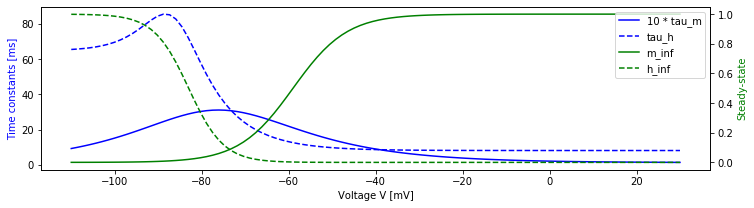

In [15]:
iT = IT(nest.GetDefaults('ht_neuron'))

V = np.linspace(-110, 30, 100)
plt.plot(V, 10 * iT.tau_m(V), 'b-', label='10 * tau_m');
plt.plot(V, iT.tau_h(V), 'b--', label='tau_h');
ax1 = plt.gca();
ax1.set_xlabel('Voltage V [mV]');
ax1.set_ylabel('Time constants [ms]', color='b');
ax2 = ax1.twinx()
ax2.plot(V, iT.m_inf(V), 'g-', label='m_inf');
ax2.plot(V, iT.h_inf(V), 'g--', label='h_inf');
ax2.set_ylabel('Steady-state', color='g');
ln1, lb1 = ax1.get_legend_handles_labels()
ln2, lb2 = ax2.get_legend_handles_labels()
plt.legend(ln1+ln2, lb1+lb2, loc='upper right');

- Time constants here are much shorter than for I_h
- Time constants are about five times shorter than in Fig 1 of Huguenard and McCormick, *J Neurophysiol* 68:1373, 1992, cited in [HT05], but that may be due to the fact that the original data was collected at 23-25C and parameters have been adjusted to 36C.
- Steady-state activation and inactivation look much like in Huguenard and McCormick.
- Note: Most detailed paper on data is Huguenard and Prince, *J Neurosci* 12:3804-3817, 1992. The parameters given for h_inf here are for VB cells, not nRT cells in that paper (Fig 5B), parameters for m_inf are similar to but not exactly those of Fig 4B for either VB or nRT.

In [16]:
iT = IT(nest.GetDefaults('ht_neuron'))
nr, cr = voltage_clamp(iT, [(200, -65.), (200, -80.), (200, -100.), (200, -90.), (200, -70.),
                           (200, -55.)],
                      nest_dt=0.1) 

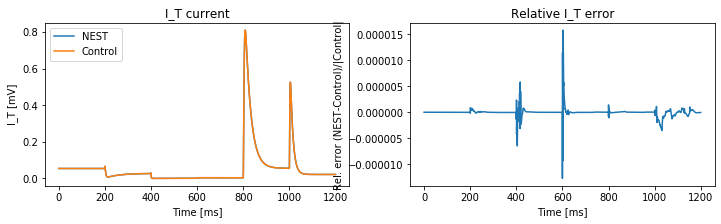

In [17]:
plt.subplot(1, 2, 1)
plt.plot(nr.times, nr.I_T, label='NEST');
plt.plot(cr.times, cr.I_T, label='Control');
plt.legend(loc='upper left');
plt.xlabel('Time [ms]');
plt.ylabel('I_T [mV]');
plt.title('I_T current')

plt.subplot(1, 2, 2)
plt.plot(nr.times, (nr.I_T-cr.I_T)/np.abs(cr.I_T));
plt.title('Relative I_T error')
plt.xlabel('Time [ms]');
plt.ylabel('Rel. error (NEST-Control)/|Control|');

- Also here the results are in good agreement and the error appears acceptable.

#### I_NaP channel

This channel adapts instantaneously to changes in membrane potential:

\begin{align}
I_{NaP} &= - g_{\text{peak}, NaP} (m_{NaP}^{\infty}(V, t))^3 (V-E_{NaP}) \\
m_{NaP}^{\infty}(V) &= \frac{1}{1+\exp\left(-\frac{V+55.7\text{mV}}{7.7\text{mV}}\right)}
\end{align}



In [18]:
nest.ResetKernel()
class INaP(Channel):
    
    nest_g = 'g_peak_NaP'
    nest_I = 'I_NaP'
    
    def __init__(self, ht_params):
        self.hp = ht_params
        
    def m_inf(self, V):
        return 1/(1+np.exp(-(V+55.7)/7.7))
    
    def compute_I(self, t, V, m0, h0, D0):
        return self.I_V_curve(V * np.ones_like(t)) 

    def I_V_curve(self, V):
        self.m = self.m_inf(V)
        return - self.hp['g_peak_NaP'] * self.m**3 * (V - self.hp['E_rev_NaP'])

In [19]:
iNaP = INaP(nest.GetDefaults('ht_neuron'))
V = np.arange(-110., 30., 1.)
nr, cr = voltage_clamp(iNaP, [(1, v) for v in V], nest_dt=0.1)

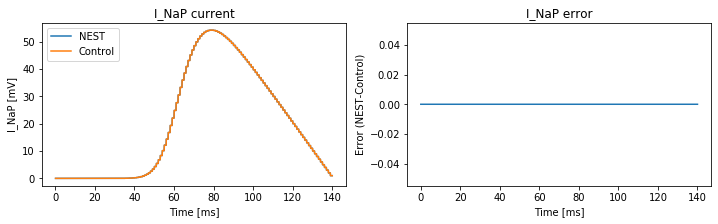

In [20]:
plt.subplot(1, 2, 1)
plt.plot(nr.times, nr.I_NaP, label='NEST');
plt.plot(cr.times, cr.I_NaP, label='Control');
plt.legend(loc='upper left');
plt.xlabel('Time [ms]');
plt.ylabel('I_NaP [mV]');
plt.title('I_NaP current')

plt.subplot(1, 2, 2)
plt.plot(nr.times, (nr.I_NaP-cr.I_NaP));
plt.title('I_NaP error')
plt.xlabel('Time [ms]');
plt.ylabel('Error (NEST-Control)');

- Perfect agreement
- Step structure is because $V$ changes only every second.

##### I_KNa channel (aka I_DK)

Equations for this channel are

\begin{align}
I_{DK} &= - g_{\text{peak},DK} m_{DK}(V,t) (V - E_{DK})\\
 m_{DK} &= \frac{1}{1 + \left(\frac{d_{1/2}}{D}\right)^{3.5}}\\
 \frac{dD}{dt} &= D_{\text{influx}}(V) - \frac{D-D_{\text{eq}}}{\tau_D} = \frac{D_{\infty}(V)-D}{\tau_D} \\
 D_{\infty}(V) &= \tau_D D_{\text{influx}}(V) + {D_{\text{eq}}}\\
 D_{\text{influx}} &= \frac{D_{\text{influx,peak}}}{1+ \exp\left(-\frac{V-D_{\theta}}{\sigma_D}\right)} 
\end{align}

with 

|$D_{\text{influx,peak}}$|$D_{\text{eq}}$|$\tau_D$|$D_{\theta}$|$\sigma_D$|$d_{1/2}$|
| --: | --: | --: | --: | --: | --: |
|$0.025\text{ms}^{-1}$ |$0.001$|$1250\text{ms}$|$-10\text{mV}$|$5\text{mV}$|$0.25$|

Note the following:
- $D_{eq}$ is the equilibrium value only for $D_{\text{influx}}(V)=0$, i.e., in the limit $V\to -\infty$ and $t\to\infty$.
- The actual steady-state value is $D_{\infty}$.
- $m_{DK}$ is a steep sigmoid which is almost 0 or 1 except for a narrow window around $d_{1/2}$.
- To the left of this window, $I_{DK}\approx 0$.
- To the right of this window, $I_{DK}\sim -(V-E_{DK})$.
- $m_{DK}$ is not integrated over time, instead it is an instantaneous transform of $D$, which is integrated over time.

In [21]:
nest.ResetKernel()
class IDK(Channel):
    
    nest_g = 'g_peak_KNa'
    nest_I = 'I_KNa'
    
    def __init__(self, ht_params):
        self.hp = ht_params
        
    def m_DK(self, D):
        return 1/(1+(0.25/D)**3.5)

    def D_inf(self, V):
        return 1250. * self.D_influx(V) + 0.001
    
    def D_influx(self, V):
        return 0.025 / ( 1 + np.exp(-(V+10)/5.) )
    
    def dD(self, D, t, V):
        return (self.D_inf(V) - D)/1250.
    
    def compute_I(self, t, V, m0, h0, D0):
        self.D = si.odeint(self.dD, D0, t, args=(V,))
        self.m = self.m_DK(self.D)
        return - self.hp['g_peak_KNa'] * self.m * (V - self.hp['E_rev_KNa'])

###### Properties of I_DK

In [22]:
iDK = IDK(nest.GetDefaults('ht_neuron'))

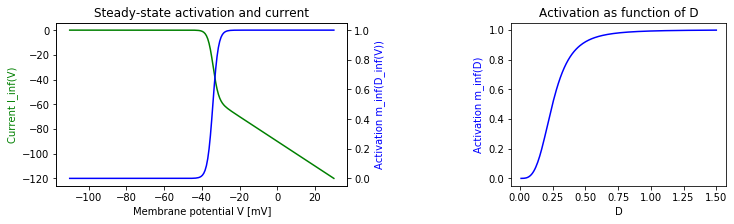

In [23]:
D=np.linspace(0.01, 1.5,num=200);
V=np.linspace(-110, 30, num=200);

ax1 = plt.subplot2grid((1, 9), (0, 0), colspan=4);
ax2 = ax1.twinx()
ax3 = plt.subplot2grid((1, 9), (0, 6), colspan=3);

ax1.plot(V, -iDK.m_DK(iDK.D_inf(V))*(V - iDK.hp['E_rev_KNa']), 'g');
ax1.set_ylabel('Current I_inf(V)', color='g');
ax2.plot(V, iDK.m_DK(iDK.D_inf(V)), 'b');
ax2.set_ylabel('Activation m_inf(D_inf(V))', color='b');
ax1.set_xlabel('Membrane potential V [mV]');
ax2.set_title('Steady-state activation and current');

ax3.plot(D, iDK.m_DK(D), 'b');
ax3.set_xlabel('D');
ax3.set_ylabel('Activation m_inf(D)', color='b');
ax3.set_title('Activation as function of D');

- Note that current in steady state is 
    - $\approx 0$ for $V < -40$mV
    - $\sim -(V-E_{DK})$ for $V> -30$mV

###### Voltage clamp

In [24]:
nr, cr = voltage_clamp(iDK, [(500, -65.), (500, -35.), (500, -25.), (500, 0.), (5000, -70.)],
                      nest_dt=1.) 

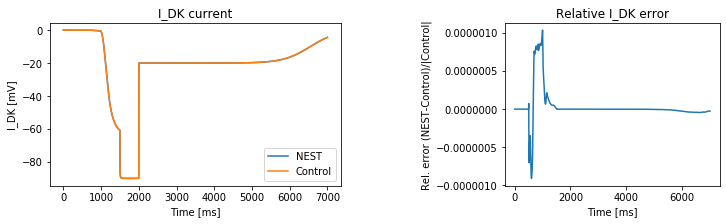

In [25]:
ax1 = plt.subplot2grid((1, 9), (0, 0), colspan=4);
ax2 = plt.subplot2grid((1, 9), (0, 6), colspan=3);

ax1.plot(nr.times, nr.I_KNa, label='NEST');
ax1.plot(cr.times, cr.I_KNa, label='Control');
ax1.legend(loc='lower right');
ax1.set_xlabel('Time [ms]');
ax1.set_ylabel('I_DK [mV]');
ax1.set_title('I_DK current');

ax2.plot(nr.times, (nr.I_KNa-cr.I_KNa)/np.abs(cr.I_KNa));
ax2.set_title('Relative I_DK error')
ax2.set_xlabel('Time [ms]');
ax2.set_ylabel('Rel. error (NEST-Control)/|Control|');

- Looks very fine.
- Note that the current gets appreviable only when $V>-35$ mV
- Once that threshold is crossed, the current adjust instantaneously to changes in $V$, since it is in the linear regime.
- When returning from $V=0$ to $V=-70$ mV, the current remains large for a long time since $D$ has to drop below 1 before $m_{\infty}$ changes appreciably

#### Synaptic channels

For synaptic channels, NEST allows recording of conductances, so we test conductances directly. Due to the voltage-dependence of the NMDA channels, we still do this in voltage clamp.

In [26]:
nest.ResetKernel()
class SynChannel:
    """
    Base class for synapse channel models in Python.
    """

    def t_peak(self):
        return self.tau_1 * self.tau_2 / (self.tau_2 - self.tau_1) * np.log(self.tau_2/self.tau_1)
    
    def beta(self, t):
        val = ( ( np.exp(-t/self.tau_1) - np.exp(-t/self.tau_2) ) /
                ( np.exp(-self.t_peak()/self.tau_1) - np.exp(-self.t_peak()/self.tau_2) ) )
        val[t < 0] = 0
        return val

In [27]:
def syn_voltage_clamp(channel, DT_V_seq, nest_dt=0.1):
    "Run voltage clamp with voltage V through intervals DT with single spike at time 1"

    spike_time = 1.0
    delay = 1.0
    
    nest.ResetKernel()
    nest.SetKernelStatus({'resolution': nest_dt})
    try:
        nrn = nest.Create('ht_neuron', params={'theta': 1e6, 'theta_eq': 1e6,
                                               'instant_unblock_NMDA': channel.instantaneous})
    except:
        nrn = nest.Create('ht_neuron', params={'theta': 1e6, 'theta_eq': 1e6})

    mm = nest.Create('multimeter', 
                     params={'record_from': ['g_'+channel.receptor],
                             'interval': nest_dt})
    sg = nest.Create('spike_generator', params={'spike_times': [spike_time]})
    nest.Connect(mm, nrn)
    nest.Connect(sg, nrn, syn_spec={'weight': 1.0, 'delay': delay,
                                    'receptor_type': channel.rec_code})

    # ensure we start from equilibrated state
    nrn.set(V_m=DT_V_seq[0][1], equilibrate=True, voltage_clamp=True)
    for DT, V in DT_V_seq:
        nrn.set(V_m=V, voltage_clamp=True)
        nest.Simulate(DT)
    t_end = nest.GetKernelStatus('time')
    
    # simulate a little more so we get all data up to t_end to multimeter
    nest.Simulate(2 * nest.GetKernelStatus('min_delay'))
    
    tmp = pd.DataFrame(mm.get('events'))
    nest_res = tmp[tmp.times <= t_end]
    
    # Control part
    t_old = 0.
    t_all, g_all = [], []
        
    m_fast_old = (channel.m_inf(DT_V_seq[0][1]) 
                 if channel.receptor == 'NMDA' and not channel.instantaneous else None)    
    m_slow_old = (channel.m_inf(DT_V_seq[0][1]) 
                 if channel.receptor == 'NMDA' and not channel.instantaneous else None)    

    for DT, V in DT_V_seq:
        t_loc = np.arange(0., DT+0.1*nest_dt, nest_dt)
        g_loc = channel.g(t_old+t_loc-(spike_time+delay), V, m_fast_old, m_slow_old)
        t_all.extend(t_old + t_loc[1:])
        g_all.extend(g_loc[1:])
        m_fast_old = channel.m_fast[-1] if m_fast_old is not None else None
        m_slow_old = channel.m_slow[-1] if m_slow_old is not None else None
        t_old = t_all[-1]
        
    ctrl_res = pd.DataFrame({'times': t_all, 'g_'+channel.receptor: g_all})

    return nest_res, ctrl_res

##### AMPA, GABA_A, GABA_B channels

In [28]:
nest.ResetKernel()
class PlainChannel(SynChannel):
    def __init__(self, hp, receptor):
        self.hp = hp
        self.receptor = receptor
        self.rec_code = hp['receptor_types'][receptor]
        self.tau_1 = hp['tau_rise_'+receptor]
        self.tau_2 = hp['tau_decay_'+receptor]
        self.g_peak = hp['g_peak_'+receptor]
        self.E_rev = hp['E_rev_'+receptor]
        
    def g(self, t, V, mf0, ms0):
        return self.g_peak * self.beta(t)
    
    def I(self, t, V):
        return - self.g(t) * (V-self.E_rev)

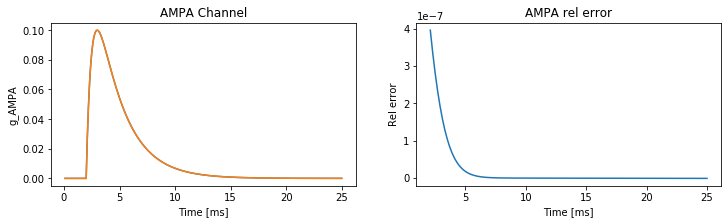

In [29]:
ampa = PlainChannel(nest.GetDefaults('ht_neuron'), 'AMPA')
am_n, am_c = syn_voltage_clamp(ampa, [(25, -70.)], nest_dt=0.1)
plt.subplot(1, 2, 1);
plt.plot(am_n.times, am_n.g_AMPA, label='NEST');
plt.plot(am_c.times, am_c.g_AMPA, label='Control');
plt.xlabel('Time [ms]');
plt.ylabel('g_AMPA');
plt.title('AMPA Channel');
plt.subplot(1, 2, 2);
plt.plot(am_n.times, (am_n.g_AMPA-am_c.g_AMPA)/am_c.g_AMPA);
plt.xlabel('Time [ms]');
plt.ylabel('Rel error');
plt.title('AMPA rel error');

- Looks quite good, but the error is maybe a bit larger than one would hope.
- But the synaptic rise time is short (0.5 ms) compared to the integration step in NEST (0.1 ms), which may explain the error.
- Reducing the time step reduces the error:

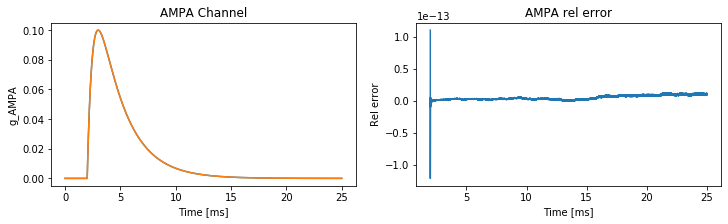

In [30]:
ampa = PlainChannel(nest.GetDefaults('ht_neuron'), 'AMPA')
am_n, am_c = syn_voltage_clamp(ampa, [(25, -70.)], nest_dt=0.001)
plt.subplot(1, 2, 1);
plt.plot(am_n.times, am_n.g_AMPA, label='NEST');
plt.plot(am_c.times, am_c.g_AMPA, label='Control');
plt.xlabel('Time [ms]');
plt.ylabel('g_AMPA');
plt.title('AMPA Channel');
plt.subplot(1, 2, 2);
plt.plot(am_n.times, (am_n.g_AMPA-am_c.g_AMPA)/am_c.g_AMPA);
plt.xlabel('Time [ms]');
plt.ylabel('Rel error');
plt.title('AMPA rel error');

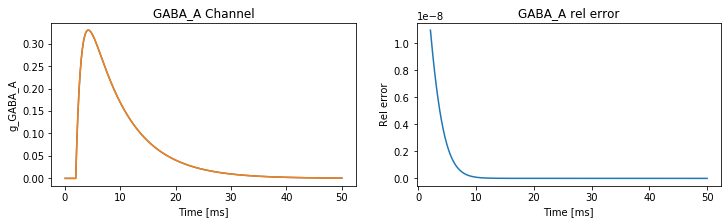

In [31]:
gaba_a = PlainChannel(nest.GetDefaults('ht_neuron'), 'GABA_A')
ga_n, ga_c = syn_voltage_clamp(gaba_a, [(50, -70.)])
plt.subplot(1, 2, 1);
plt.plot(ga_n.times, ga_n.g_GABA_A, label='NEST');
plt.plot(ga_c.times, ga_c.g_GABA_A, label='Control');
plt.xlabel('Time [ms]');
plt.ylabel('g_GABA_A');
plt.title('GABA_A Channel');
plt.subplot(1, 2, 2);
plt.plot(ga_n.times, (ga_n.g_GABA_A-ga_c.g_GABA_A)/ga_c.g_GABA_A);
plt.xlabel('Time [ms]');
plt.ylabel('Rel error');
plt.title('GABA_A rel error');

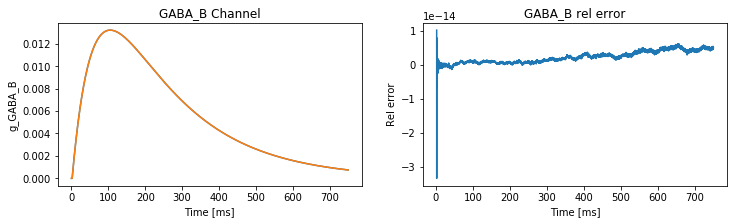

In [32]:
gaba_b = PlainChannel(nest.GetDefaults('ht_neuron'), 'GABA_B')
gb_n, gb_c = syn_voltage_clamp(gaba_b, [(750, -70.)])
plt.subplot(1, 2, 1);
plt.plot(gb_n.times, gb_n.g_GABA_B, label='NEST');
plt.plot(gb_c.times, gb_c.g_GABA_B, label='Control');
plt.xlabel('Time [ms]');
plt.ylabel('g_GABA_B');
plt.title('GABA_B Channel');
plt.subplot(1, 2, 2);
plt.plot(gb_n.times, (gb_n.g_GABA_B-gb_c.g_GABA_B)/gb_c.g_GABA_B);
plt.xlabel('Time [ms]');
plt.ylabel('Rel error');
plt.title('GABA_B rel error');

- Looks good for all
- For GABA_B the error is negligible even for dt = 0.1, since the time constants are large.

##### NMDA Channel

The equations for this channel are

\begin{align}
    \bar{g}_{\text{NMDA}}(t) &= m(V, t) g_{\text{NMDA}}(t)     m(V, t)\\ &= a(V) m_{\text{fast}}^*(V, t) + ( 1 - a(V) ) m_{\text{slow}}^*(V, t)\\
     a(V)    &= 0.51 - 0.0028 V \\
     m^{\infty}(V) &= \frac{1}{ 1 + \exp\left( -S_{\text{act}} ( V - V_{\text{act}} ) \right) } \\
     m_X^*(V, t) &= \min(m^{\infty}(V), m_X(V, t))\\
      \frac{\text{d}m_X}{\text{d}t} &= \frac{m^{\infty}(V) - m_X }{ \tau_{\text{Mg}, X}}
\end{align} 

where $g_{\text{NMDA}}(t)$ is the beta functions as for the other channels. In case of instantaneous unblocking, $m=m^{\infty}$.

###### NMDA with instantaneous unblocking

In [33]:
class NMDAInstantChannel(SynChannel):
    def __init__(self, hp, receptor):
        self.hp = hp
        self.receptor = receptor
        self.rec_code = hp['receptor_types'][receptor]
        self.tau_1 = hp['tau_rise_'+receptor]
        self.tau_2 = hp['tau_decay_'+receptor]
        self.g_peak = hp['g_peak_'+receptor]
        self.E_rev = hp['E_rev_'+receptor]
        self.S_act = hp['S_act_NMDA']
        self.V_act = hp['V_act_NMDA']
        self.instantaneous = True
        
    def m_inf(self, V):
        return 1. / ( 1. + np.exp(-self.S_act*(V-self.V_act)))
    
    def g(self, t, V, mf0, ms0):
        return self.g_peak * self.m_inf(V) * self.beta(t)
    
    def I(self, t, V):
        return - self.g(t) * (V-self.E_rev)

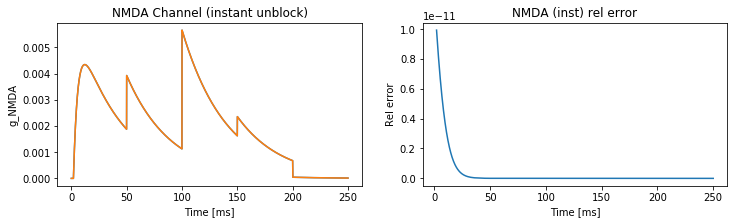

In [34]:
nmdai = NMDAInstantChannel(nest.GetDefaults('ht_neuron'), 'NMDA')
ni_n, ni_c = syn_voltage_clamp(nmdai, [(50, -60.), (50, -50.), (50, -20.), (50, 0.), (50, -60.)])
plt.subplot(1, 2, 1);
plt.plot(ni_n.times, ni_n.g_NMDA, label='NEST');
plt.plot(ni_c.times, ni_c.g_NMDA, label='Control');
plt.xlabel('Time [ms]');
plt.ylabel('g_NMDA');
plt.title('NMDA Channel (instant unblock)');
plt.subplot(1, 2, 2);
plt.plot(ni_n.times, (ni_n.g_NMDA-ni_c.g_NMDA)/ni_c.g_NMDA);
plt.xlabel('Time [ms]');
plt.ylabel('Rel error');
plt.title('NMDA (inst) rel error');

- Looks good
- Jumps are due to blocking/unblocking of Mg channels with changes in $V$

###### NMDA with unblocking over time

In [35]:
class NMDAChannel(SynChannel):
    def __init__(self, hp, receptor):
        self.hp = hp
        self.receptor = receptor
        self.rec_code = hp['receptor_types'][receptor]
        self.tau_1 = hp['tau_rise_'+receptor]
        self.tau_2 = hp['tau_decay_'+receptor]
        self.g_peak = hp['g_peak_'+receptor]
        self.E_rev = hp['E_rev_'+receptor]
        self.S_act = hp['S_act_NMDA']
        self.V_act = hp['V_act_NMDA']
        self.tau_fast = hp['tau_Mg_fast_NMDA']
        self.tau_slow = hp['tau_Mg_slow_NMDA']
        self.instantaneous = False
        
    def m_inf(self, V):
        return 1. / ( 1. + np.exp(-self.S_act*(V-self.V_act)) )
    
    def dm(self, m, t, V, tau):
        return ( self.m_inf(V) - m ) / tau

    def g(self, t, V, mf0, ms0):
        self.m_fast = si.odeint(self.dm, mf0, t, args=(V, self.tau_fast))
        self.m_slow = si.odeint(self.dm, ms0, t, args=(V, self.tau_slow))
        a = 0.51 - 0.0028 * V
        m_inf = self.m_inf(V)
        mfs = self.m_fast[:]
        mfs[mfs > m_inf] = m_inf
        mss = self.m_slow[:]
        mss[mss > m_inf] = m_inf
        m = np.squeeze(a * mfs + ( 1 - a ) * mss)
        return self.g_peak * m * self.beta(t)
    
    def I(self, t, V):
        raise NotImplementedError()

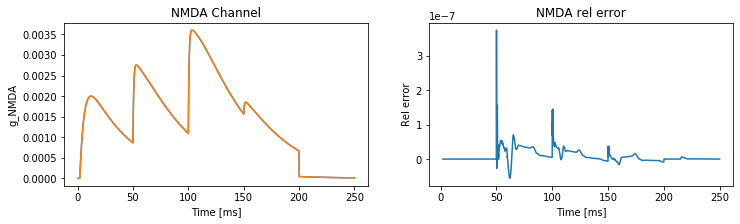

In [36]:
nmda = NMDAChannel(nest.GetDefaults('ht_neuron'), 'NMDA')
nm_n, nm_c = syn_voltage_clamp(nmda, [(50, -70.), (50, -50.), (50, -20.), (50, 0.), (50, -60.)])
plt.subplot(1, 2, 1);
plt.plot(nm_n.times, nm_n.g_NMDA, label='NEST');
plt.plot(nm_c.times, nm_c.g_NMDA, label='Control');
plt.xlabel('Time [ms]');
plt.ylabel('g_NMDA');
plt.title('NMDA Channel');
plt.subplot(1, 2, 2);
plt.plot(nm_n.times, (nm_n.g_NMDA-nm_c.g_NMDA)/nm_c.g_NMDA);
plt.xlabel('Time [ms]');
plt.ylabel('Rel error');
plt.title('NMDA rel error');

- Looks fine, too.

### Synapse Model

We test the synapse model by placing it between two parrot neurons, sending spikes with differing intervals and compare to expected weights.

In [37]:
nest.ResetKernel()
sp = nest.GetDefaults('ht_synapse')
P0 = sp['P']
dP = sp['delta_P']
tP = sp['tau_P']
spike_times = [10., 12., 20., 20.5, 100., 200., 1000.]
expected = [(0., P0, P0)]
for idx, t in enumerate(spike_times):
    tlast, Psend, Ppost = expected[idx]
    Psend = 1 - (1-Ppost)*math.exp(-(t-tlast)/tP)
    expected.append((t, Psend, (1-dP)*Psend))
expected_weights = list(zip(*expected[1:]))[1]

sg = nest.Create('spike_generator', params={'spike_times': spike_times})
n = nest.Create('parrot_neuron', 2)
wr = nest.Create('weight_recorder')

nest.SetDefaults('ht_synapse', {'weight_recorder': wr, 'weight': 1.0})
nest.Connect(sg, n[:1])
nest.Connect(n[:1], n[1:], syn_spec='ht_synapse')
nest.Simulate(1200)

rec_weights = wr.get('events', 'weights')

print('Recorded weights:', rec_weights)
print('Expected weights:', expected_weights)
print('Difference      :', np.array(rec_weights) - np.array(expected_weights))

Recorded weights: [1.         0.875499   0.76977486 0.67387928 0.64996814 0.64689954
 0.9123844 ]
Expected weights: (1.0, 0.8754990013320011, 0.7697748551001631, 0.6738792820453234, 0.6499681432540876, 0.6468995408997453, 0.9123844012053444)
Difference      : [0. 0. 0. 0. 0. 0. 0.]


Perfect agreement, synapse model looks fine.

## Integration test: Neuron driven through all synapses

We drive a Hill-Tononi neuron through pulse packets arriving at 1 second intervals, impinging through all synapse types. Compare this to Fig 5 of [HT05].

In [38]:
nest.ResetKernel()
nrn = nest.Create('ht_neuron')
ppg = nest.Create('pulsepacket_generator', n=4,
                  params={'pulse_times': [700., 1700., 2700., 3700.],
                          'activity': 700, 'sdev': 50.})
pr = nest.Create('parrot_neuron', n=4)
mm = nest.Create('multimeter', 
                 params={'interval': 0.1,
                         'record_from': ['V_m', 'theta',
                                         'g_AMPA', 'g_NMDA',
                                         'g_GABA_A', 'g_GABA_B',
                                         'I_NaP', 'I_KNa', 'I_T', 'I_h']})

weights = {'AMPA': 25., 'NMDA': 20., 'GABA_A': 10., 'GABA_B': 1.}
receptors = nest.GetDefaults('ht_neuron')['receptor_types']

nest.Connect(ppg, pr, 'one_to_one')
for p, (rec_name, rec_wgt) in zip(pr, weights.items()):
    nest.Connect(p, nrn, syn_spec={'synapse_model': 'ht_synapse',
                                   'receptor_type': receptors[rec_name],
                                   'weight': rec_wgt})
nest.Connect(mm, nrn)

nest.Simulate(5000)

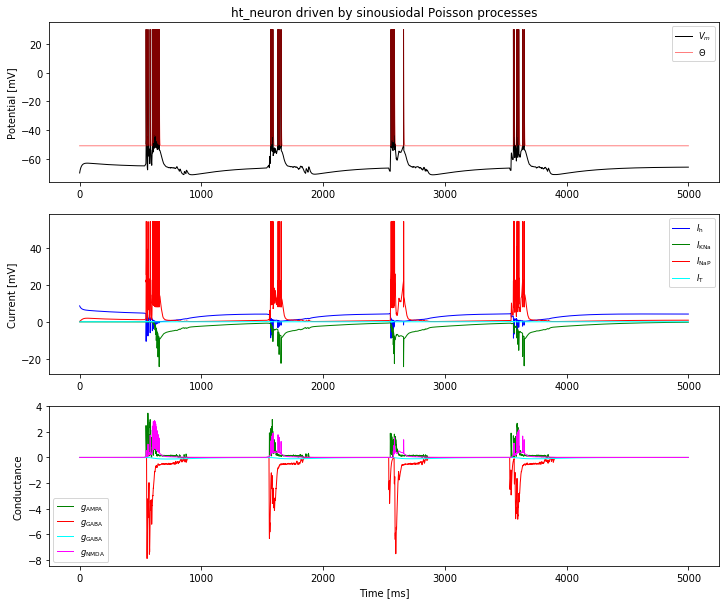

In [39]:
data = nest.GetStatus(mm)[0]['events']
t = data['times']
def texify_name(name):
    return r'${}_{{\mathrm{{{}}}}}$'.format(*name.split('_'))

fig = plt.figure(figsize=(12,10))

Vax = fig.add_subplot(311)
Vax.plot(t, data['V_m'], 'k', lw=1, label=r'$V_m$')
Vax.plot(t, data['theta'], 'r', alpha=0.5, lw=1, label=r'$\Theta$')
Vax.set_ylabel('Potential [mV]')
Vax.legend(fontsize='small')
Vax.set_title('ht_neuron driven by sinousiodal Poisson processes')

Iax = fig.add_subplot(312)
for iname, color in (('I_h', 'blue'), ('I_KNa', 'green'),
                     ('I_NaP', 'red'), ('I_T', 'cyan')):
    Iax.plot(t, data[iname], color=color, lw=1, label=texify_name(iname))
#Iax.set_ylim(-60, 60)
Iax.legend(fontsize='small')
Iax.set_ylabel('Current [mV]')

Gax = fig.add_subplot(313)
for gname, sgn, color in (('g_AMPA', 1, 'green'), ('g_GABA_A', -1, 'red'), 
                          ('g_GABA_B', -1, 'cyan'), ('g_NMDA', 1, 'magenta')):
    Gax.plot(t, sgn*data[gname], lw=1, label=texify_name(gname), color=color)
#Gax.set_ylim(-150, 150)
Gax.legend(fontsize='small')
Gax.set_ylabel('Conductance')
Gax.set_xlabel('Time [ms]');